In [1]:
import sys
import os
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json
os.system("")

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

Welcome to JupyROOT 6.20/06


In [2]:
from Tools.PlotTools import *

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:

if in_ipynb(): 
    print("In IPython")
    exec("import Tools.TrainConfig as Conf")
    TrainConfig="Tools/TrainConfig"
else:
    TrainConfig=sys.argv[1]
    prGreen("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")
    


W0326 09:54:44.345851 140449887389504 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'IPKernelApp': {'connection_file': '/scratch/akapoor/.local/share/jupyter/runtime/kernel-fbc300d5-633a-445b-8bbd-b54d061205db.json'}, 'InteractiveShellApp': {'extensions': <traitlets.config.loader.LazyConfigValue object at 0x7fbcf62a97d0>}}
In IPython


In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

 Running in debug mode : Only every 10th event will be used


In [6]:
if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd)
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")

 Making output directory


0

In [7]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [8]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(Conf.SigFiles,Conf.SigXsecWts,Conf.SigCuts):
    if Conf.Debug==True:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(Conf.BkgFiles,Conf.BkgXsecWts,Conf.BkgCuts):
    if Conf.Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)

 Making data frames


In [9]:
Sigdf[cat]=1
Bkgdf[cat]=0

Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

#Reweighing
Sigdf[weight]=1
Bkgdf[weight]=1

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

df_final["NewWt"]=1

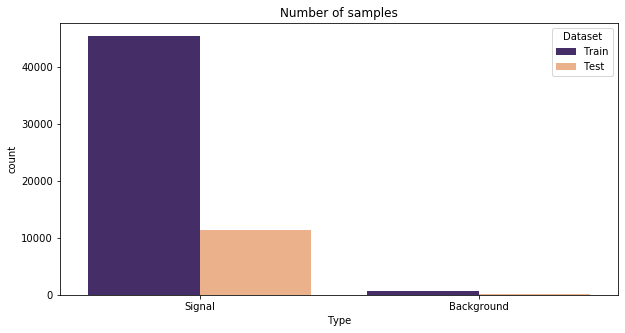

In [10]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")
    

In [11]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]

    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    Wt_train = np.asarray(Wt_train)
    
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)
    Wt_test = np.asarray(Wt_test)
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
 XGB_1 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:    8.1s finished


 Expected neg log loss of XGB model = -5.4%
 XGB Best Parameters
 {'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB
 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
 XGB_2 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    8.2s finished


 Expected neg log loss of XGB model = -5.5%
 XGB Best Parameters
 {'gamma': 1, 'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB


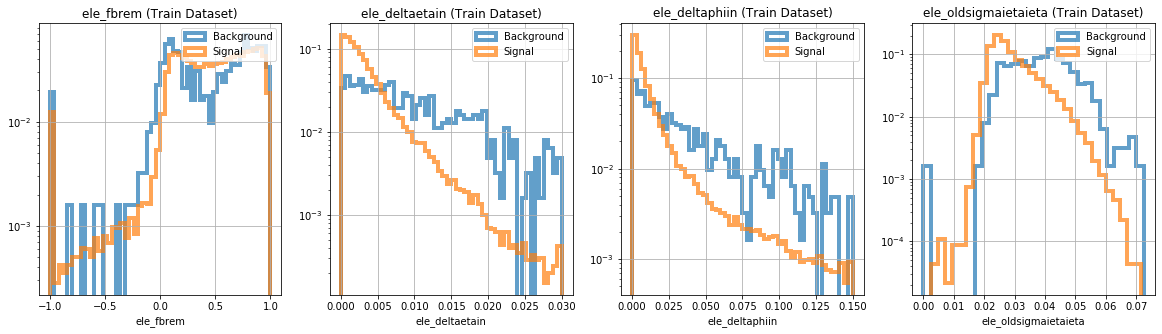

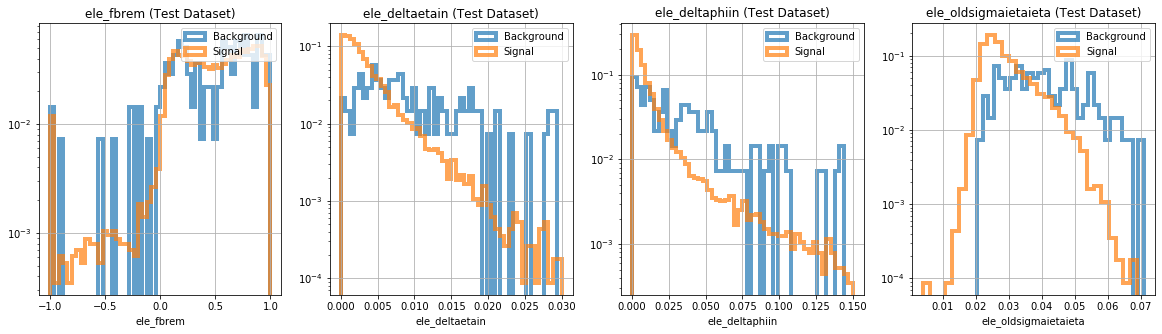

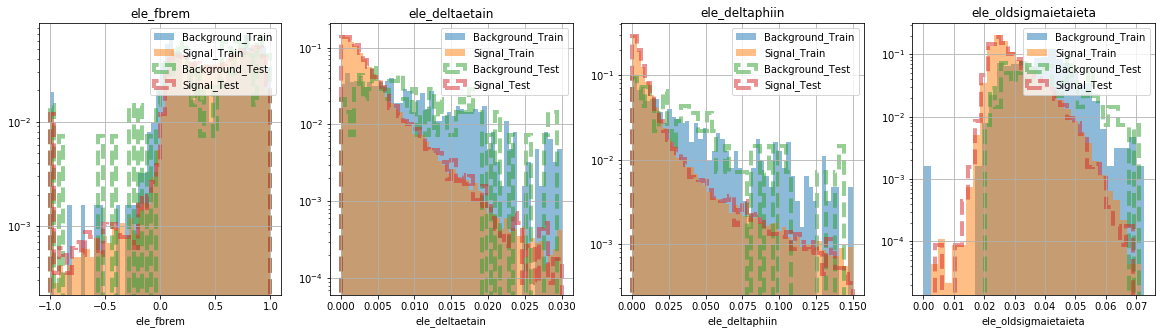

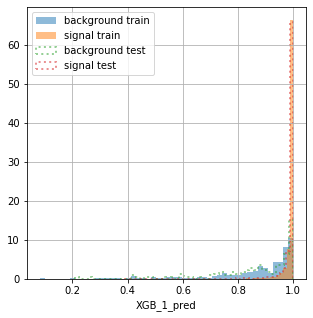

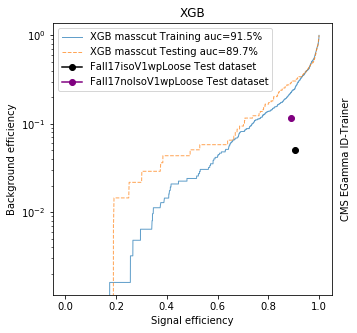

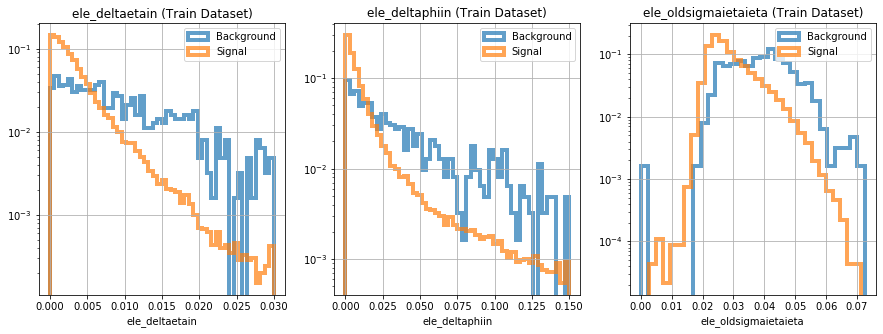

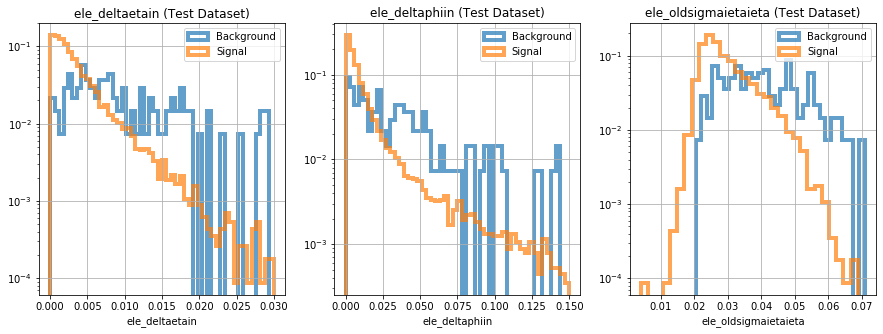

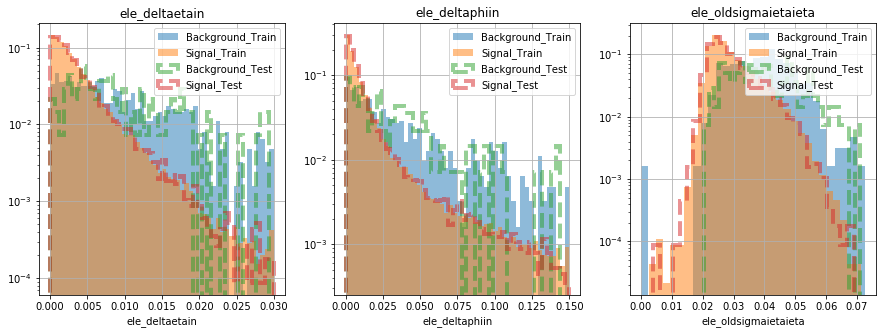

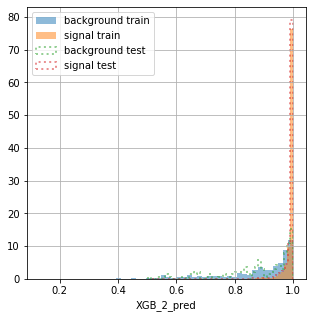

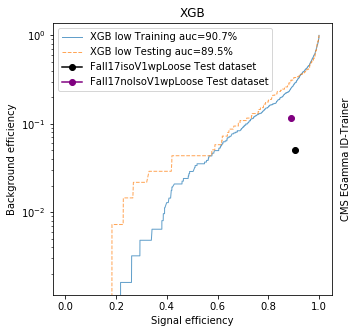

In [12]:
import pickle
import multiprocessing
for MVA in Conf.MVAs:
    
    if 'XGB' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2)#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB.pkl", "wb"))
        #modelDNN.save(Conf.OutputDirName+"/"+MVA+"_"+"modelDNN.h5")
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
    
        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("XGB")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.png")

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots


W0326 09:55:38.722379 140449887389504 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 DNN fitting running
Train on 46130 samples, validate on 11533 samples
Epoch 1/10
46130/46130 [==============================] - 1s 25us/sample - loss: 0.3534 - acc: 0.9862 - val_loss: 0.0905 - val_acc: 0.9880
Epoch 2/10
46130/46130 [==============================] - 1s 15us/sample - loss: 0.1235 - acc: 0.9865 - val_loss: 0.0704 - val_acc: 0.9880
Epoch 3/10
46130/46130 [==============================] - 1s 14us/sample - loss: 0.1164 - acc: 0.9865 - val_loss: 0.0684 - val_acc: 0.9880
Epoch 4/10
46130/46130 [==============================] - 1s 15us/sample - loss: 0.1109 - acc: 0.9865 - val_loss: 0.0670 - val_acc: 0.9880
Epoch 5/10
46130/46130 [==============================] - 1s 15us/sample - loss: 0.1041 - acc: 0.9865 - val_loss: 0.0660 - val_acc: 0.9880
Epoch 6/10
46130/46130 [==============================] - 1s 14us/sample - loss: 0.0985 - acc: 0.9865 - val_loss: 0.0643 - val_acc: 0.9880
Epoch 7/10
46130/46130 [==============================] - 1s 15us/sample - loss: 0.0937 - acc: 

2021-03-26 09:55:39.527816: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-03-26 09:55:39.542103: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2021-03-26 09:55:39.543429: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb5090e0 executing computations on platform Host. Devices:
2021-03-26 09:55:39.543465: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-03-26 09:55:39.598139: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, n

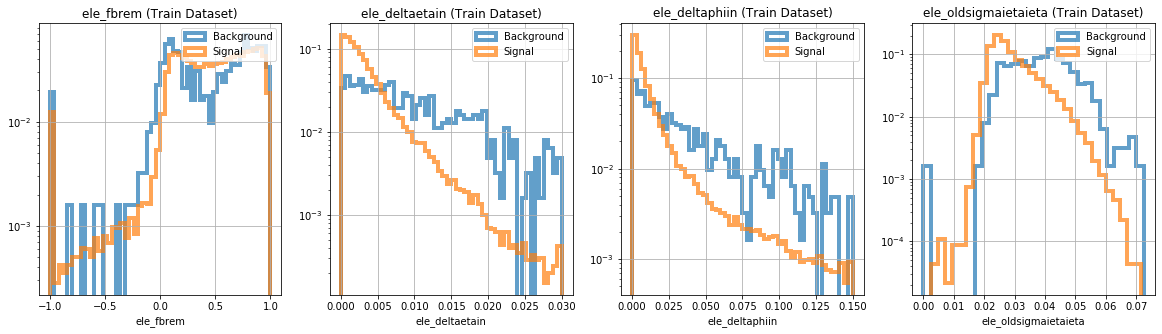

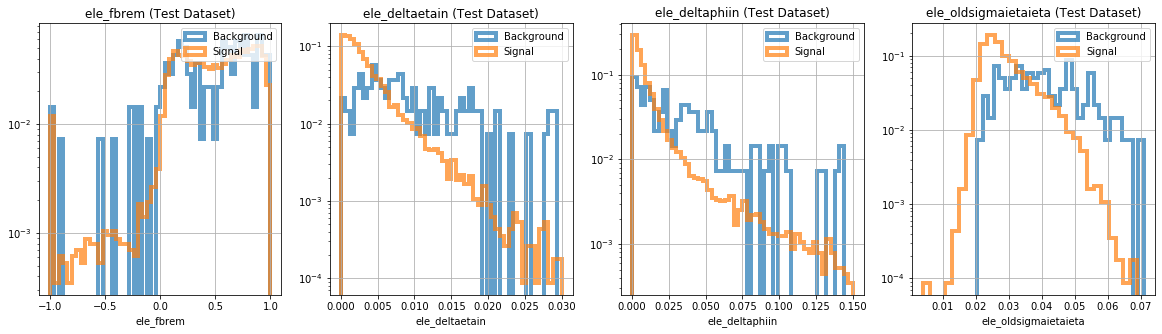

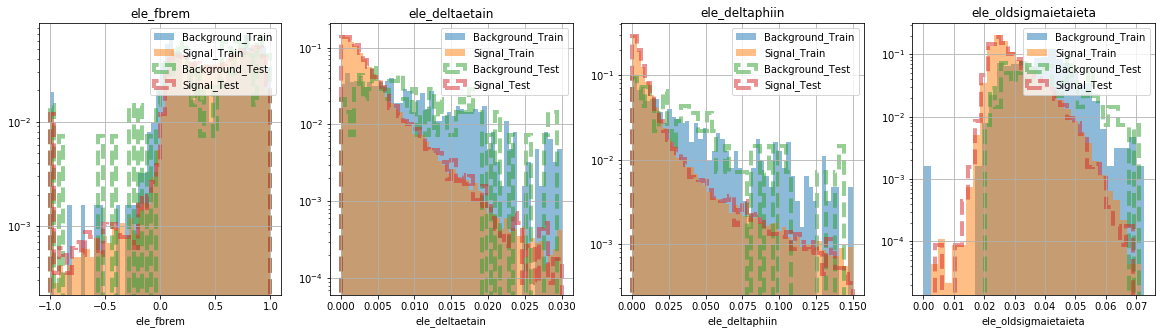

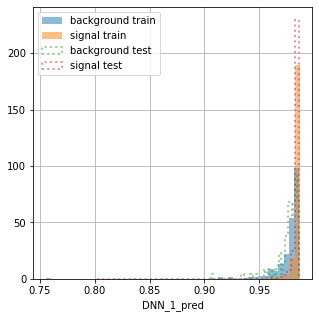

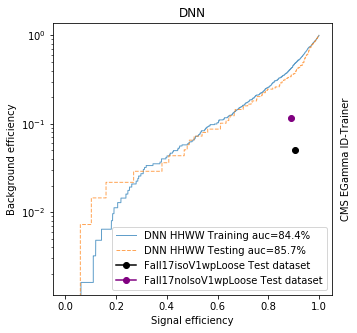

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
for MVA in Conf.MVAs:
    if 'DNN' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen("DNN fitting running")
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        modelDNN=Conf.DNNDict[MVA]['model']
        modelDNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=Conf.DNNDict[MVA]['lr']), metrics=['accuracy',])
        train_history = modelDNN.fit(X_train,Y_train,epochs=Conf.DNNDict[MVA]['epochs'],batch_size=Conf.DNNDict[MVA]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelDNN.h5")
        df_final.loc[TrainIndices,MVA+"_pred"]=modelDNN.predict(X_train)
        df_final.loc[TestIndices,MVA+"_pred"]=modelDNN.predict(X_test)
    
        prGreen("Plotting output response for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.png")
    
        prGreen("Plotting ROC for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("DNN")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.png")

In [14]:
if 'Genetic' in Conf.MVAs:
    prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

 Plotting Final ROC


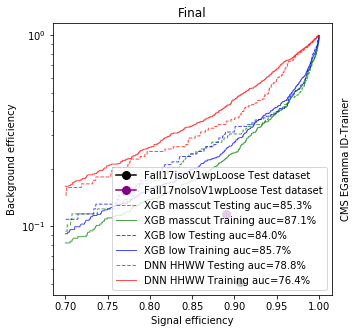

In [15]:
##PlotFinalROC
prGreen("Plotting Final ROC")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if len(Conf.OverlayWP)>0:
    for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
        plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
if len(Conf.MVAs)>0:
    for color,MVAi in zip(Conf.MVAColors,Conf.MVAs):
        plot_roc_curve(df_final.query('TrainDataset==0'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='--', label=Conf.MVALabels[MVAi]+' Testing',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==1'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='-', label=Conf.MVALabels[MVAi]+' Training',cat=cat,Wt=weight)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("Final")
    axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=axes.transAxes)
plt.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [16]:
PredMVAs=[]
for MVA in Conf.MVAs:
    PredMVAs.append(MVA+'_pred')
SigEffWPs=Conf.SigEffWPs[:]
for i,SigEffWPi in enumerate(SigEffWPs):
    SigEffWPs[i]=int(SigEffWPi.replace('%', ''))/100

if len(Conf.MVAs)>0:
    prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
    mydf=df_final.query("TrainDataset==1 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
    mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    mydf2=df_final.query("TrainDataset==0 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)
    mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
    mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

 Threshold values for requested Signal Efficiencies (Train Dataset)
      XGB_1_pred  XGB_2_pred  DNN_1_pred
WPs                                    
80%    0.998976    0.998998    0.985483
90%    0.999342    0.999346    0.985698
 Threshold values for requested Signal Efficiencies (Test Dataset)
      XGB_1_pred  XGB_2_pred  DNN_1_pred
WPs                                    
80%    0.999016    0.999013    0.985488
90%    0.999343    0.999342    0.985691


In [18]:
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')

 Done!! Please find the quick look ROC pdf here Output/mydocROC.pdf
 Done!! Please find the quick look MVA pdf here Output/mydocMVA.pdf
 Individual plots and saved model files can be found in directory: Output/
